In [117]:
import itertools as it
import warnings
from collections import deque
from typing import Dict

import multiprocess as mp
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm.notebook import tqdm

from edgedroid.models import *
from sampling_util import *

reference_name = "Adaptive\nGaussian fit"

def experimental_run(
        repetition: int,
        task_steps: int,
        rtt: float,
) -> pd.DataFrame:
    min_sr = 0.5
    alpha = 3.0

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ground_truths: Dict[str, ExecutionTimeModel] = {
            "Low" : ExpKernelRollingTTFETModel(neuroticism=0.0),
            "High": ExpKernelRollingTTFETModel(neuroticism=1.0)
        }

        samplers: Dict[str, Sampler] = {
            "Greedy"                                : GreedySampler(),
            reference_name: JunjuesSampler(
                cdf=FittedNaiveExecutionTimeModel(dist=stats.norm).get_cdf_at_instant,
                min_sr=min_sr,
                alpha=alpha,
            ),
            "Adaptive\nED2, low neuro"                 : JunjuesSampler(
                cdf=ExpKernelRollingTTFETModel(neuroticism=0.0).get_cdf_at_instant,
                min_sr=min_sr,
                alpha=alpha,
            ),
            "Adaptive\nED2, high neuro"                 : JunjuesSampler(
                cdf=ExpKernelRollingTTFETModel(neuroticism=1.0).get_cdf_at_instant,
                min_sr=min_sr,
                alpha=alpha,
            ),
            "Adaptive\nED2 ExG, low neuro"        : JunjuesSampler(
                cdf=DistExpKernelRollingTTFETModel(neuroticism=0.0, dist=stats.exponnorm).get_cdf_at_instant,
                min_sr=min_sr,
                alpha=alpha,
            ),
            "Adaptive\nED2 ExG, high neuro"        : JunjuesSampler(
                cdf=DistExpKernelRollingTTFETModel(neuroticism=1.0, dist=stats.exponnorm).get_cdf_at_instant,
                min_sr=min_sr,
                alpha=alpha,
            ),
        }

    rows = deque()

    for (gt_name, gt), (s_name, sampler) in it.product(ground_truths.items(), samplers.items()):
        gt.reset()
        prev_ttf = rtt

        for step in range(1, task_steps + 1):
            exec_time = gt.advance(prev_ttf).get_execution_time()
            sampling_result = sampler(exec_time, rtt)

            ttf = sampling_result.duration - exec_time
            wait_time = ttf - rtt

            rows.append({
                "ground_truth": gt_name,
                "sampler"     : s_name,
                "rtt"         : rtt,
                "repetition"  : repetition,
                "step"        : step,
                "exec_time"   : exec_time,
                "duration"    : sampling_result.duration,
                "ttf"         : ttf,
                "wait_time"   : wait_time,
                "num_samples" : sampling_result.num_samples,
            })

            prev_ttf = ttf

    df = pd.DataFrame(rows)
    df["ground_truth"] = df["ground_truth"].astype(pd.CategoricalDtype(ground_truths.keys(), ordered=False))
    df["sampler"] = df["sampler"].astype(pd.CategoricalDtype(samplers.keys(), ordered=False))
    return df


rtts = [0.15, 0.3, 0.6]
repetitions = 100
num_steps = 100

results = deque()
combs = list(it.product(rtts, range(1, repetitions + 1)))

with tqdm(total=len(combs)) as bar, mp.Pool() as pool:
    def _callback(df: pd.DataFrame):
        results.append(df)
        bar.update()


    def _errback(error):
        raise error


    for rtt, rep in combs:
        pool.apply_async(
            experimental_run,
            kwds=dict(repetition=rep, task_steps=num_steps, rtt=rtt),
            callback=_callback,
            error_callback=_errback,
        )

    pool.close()
    pool.join()

results = pd.concat(results)
results

  0%|          | 0/300 [00:00<?, ?it/s]

,ground_truth,sampler,rtt,repetition,step,exec_time,duration,ttf,wait_time,num_samples
0,Low,Greedy,0.15,5,1,5.911358,6.150000,0.238642,0.088642,41
1,Low,Greedy,0.15,5,2,4.133503,4.350000,0.216497,0.066497,29
2,Low,Greedy,0.15,5,3,3.117168,3.300000,0.182832,0.032832,22
3,Low,Greedy,0.15,5,4,8.273053,8.550000,0.276947,0.126947,57
4,Low,Greedy,0.15,5,5,4.516338,4.800000,0.283662,0.133662,32
...,...,...,...,...,...,...,...,...,...,...
1195,High,"Adaptive\nED2 ExG, high neuro",0.60,100,96,7.554255,8.663407,1.109153,0.509153,9
1196,High,"Adaptive\nED2 ExG, high neuro",0.60,100,97,8.446559,9.263407,0.816848,0.216848,10
1197,High,"Adaptive\nED2 ExG, high neuro",0.60,100,98,5.028678,5.663407,0.634730,0.034730,4
1198,High,"Adaptive\nED2 ExG, high neuro",0.60,100,99,9.878409,11.063407,1.184998,0.584998,13


In [118]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2.5)
sns.set_palette("Dark2")

In [119]:
# mean number of samples per rep
samples_per_rep = results.groupby(["ground_truth", "sampler", "rtt", "repetition"])["num_samples"].mean().reset_index()
samples_per_rep["rtt"] = samples_per_rep["rtt"].apply(lambda e: f"{int(e * 1000):} ms").astype(str)
samples_per_rep

,ground_truth,sampler,rtt,repetition,num_samples
0,Low,Greedy,150 ms,1,33.77
1,Low,Greedy,150 ms,2,32.60
2,Low,Greedy,150 ms,3,36.04
3,Low,Greedy,150 ms,4,34.29
4,Low,Greedy,150 ms,5,36.81
...,...,...,...,...,...
3595,High,"Adaptive\nED2 ExG, high neuro",600 ms,96,6.46
3596,High,"Adaptive\nED2 ExG, high neuro",600 ms,97,5.09
3597,High,"Adaptive\nED2 ExG, high neuro",600 ms,98,5.11
3598,High,"Adaptive\nED2 ExG, high neuro",600 ms,99,5.83


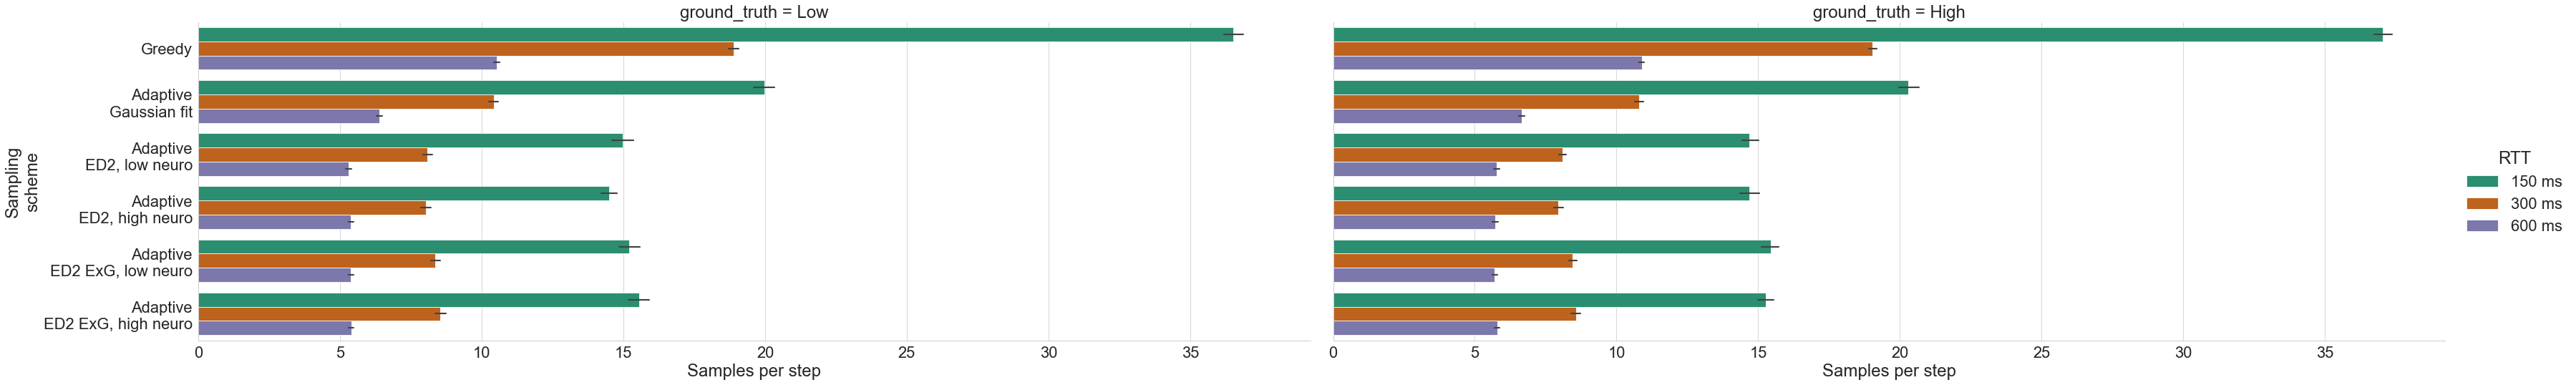

In [124]:
# import numpy as np

# order = ["Adaptive (ED2 LN)", "Adaptive (ED2 HN)", "Adaptive (ED2 LN, ExG fit)", "Adaptive (ED2 HN, ExG fit)",
#          "Adaptive (reference, gaussian fit)", "Greedy"]

fg = sns.catplot(
    kind="bar",
    # join=False,
    data=samples_per_rep,
    x="num_samples",
    hue="rtt",
    y="sampler",
    # order=order,
    col="ground_truth",
    aspect=3,
    height=8,
)
# fg.set(xticks=np.linspace(0, 40, 5))
fg.legend.set_title("RTT")
fg.set_axis_labels("Samples per step", "Sampling\nscheme")
# for ax in fg.axes.flat:
#     for i in ax.containers:
#         ax.bar_label(i, padding=-50, fmt="%0.2f")
plt.show()

In [131]:
ix = pd.IndexSlice

table = (
    samples_per_rep
    .groupby(["ground_truth", "sampler", "rtt"], observed=True)
    ["num_samples"]
    .mean()
    .unstack()
)
table.columns = [r"\SI{" f"{int(e.split()[0]):3d}" r"}{\milli\second}" for e in table.columns]
print(
    table
    # .loc[order]
    .loc[ix[:, ["Greedy", reference_name], :]]
    # .stack()
    # .unstack(level=0)
    # .stack(level=0)
    .style
    .format(lambda e: r"\num{" f"{e:0.2f}" r"}")
    .to_latex()
)

\begin{tabular}{llrrr}
 &  & \SI{150}{\milli\second} & \SI{300}{\milli\second} & \SI{600}{\milli\second} \\
ground_truth & sampler &  &  &  \\
\multirow[c]{2}{*}{Low} & Greedy & \num{36.53} & \num{18.88} & \num{10.52} \\
 & Adaptive
Gaussian fit & \num{19.97} & \num{10.43} & \num{6.39} \\
\multirow[c]{2}{*}{High} & Greedy & \num{37.05} & \num{19.04} & \num{10.89} \\
 & Adaptive
Gaussian fit & \num{20.29} & \num{10.79} & \num{6.67} \\
\end{tabular}



In [122]:
import pingouin as pg

ix = pd.IndexSlice


def diff_wrt_ref_rtt(df: pd.DataFrame) -> pd.DataFrame:
    ref_samples = df.loc[df["sampler"] == reference_name, "num_samples"].to_numpy()
    ref_mean = ref_samples.mean()

    def diff_wrt_ref(samples: pd.Series) -> pd.Series:
        ttest = pg.ttest(samples.to_numpy(), ref_samples, alternative="two-sided")
        diff_raw = samples.mean() - ref_mean
        diff = diff_raw / ref_mean
        ci = ttest.at["T-test", "CI95%"]

        pval = ttest.at["T-test", "p-val"]
        sig_pval = pval < 0.05

        return pd.Series({
            "diff"     : diff,
            "diff_raw" : diff_raw,
            "p-val"    : pval,
            "p < 0.05" : sig_pval,
            "CI95_Low" : ci[0] / ref_mean,
            "CI95_High": ci[1] / ref_mean}, name="Result")

    return df.groupby("sampler")["num_samples"].apply(diff_wrt_ref)


samples_diff = samples_per_rep.groupby(["ground_truth", "rtt"]).apply(diff_wrt_ref_rtt).stack().stack().unstack(level=2).reset_index()
samples_diff = samples_diff[samples_diff["sampler"] != reference_name]
samples_diff["sampler"] = samples_diff["sampler"].cat.remove_unused_categories()
samples_diff

,ground_truth,rtt,sampler,diff,diff_raw,p-val,p < 0.05,CI95_Low,CI95_High
0,Low,150 ms,Greedy,0.829208,16.5578,0.0,True,0.803277,0.85536
2,Low,150 ms,"Adaptive\nED2, low neuro",-0.250273,-4.9975,0.0,True,-0.27644,-0.223856
3,Low,150 ms,"Adaptive\nED2, high neuro",-0.274306,-5.4774,0.0,True,-0.297473,-0.250899
4,Low,150 ms,"Adaptive\nED2 ExG, low neuro",-0.23884,-4.7692,0.0,True,-0.26442,-0.213339
5,Low,150 ms,"Adaptive\nED2 ExG, high neuro",-0.220726,-4.4075,0.0,True,-0.245891,-0.195311
6,Low,300 ms,Greedy,0.810956,8.4543,0.0,True,0.787522,0.834524
8,Low,300 ms,"Adaptive\nED2, low neuro",-0.224564,-2.3411,0.0,True,-0.24748,-0.202396
9,Low,300 ms,"Adaptive\nED2, high neuro",-0.229561,-2.3932,0.0,True,-0.252276,-0.207192
10,Low,300 ms,"Adaptive\nED2 ExG, low neuro",-0.197475,-2.0587,0.0,True,-0.219662,-0.175538
11,Low,300 ms,"Adaptive\nED2 ExG, high neuro",-0.180497,-1.8817,0.0,True,-0.204315,-0.156353


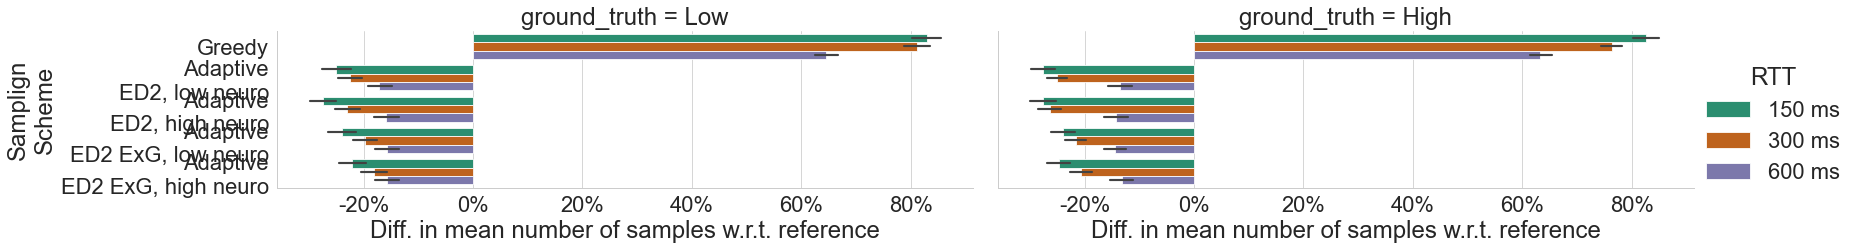

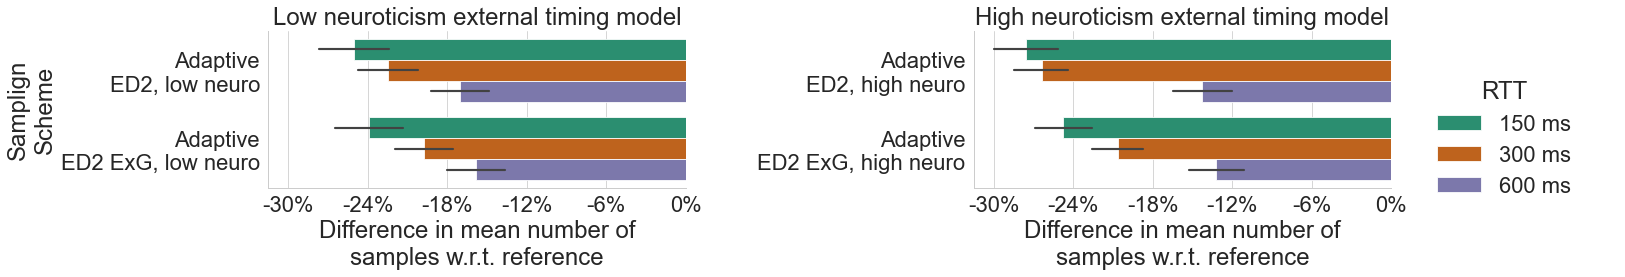

In [129]:
import matplotlib.ticker as tkr

plot_data = samples_diff.set_index(["ground_truth", "sampler", "rtt"])[
    ["CI95_Low", "CI95_High", "diff"]].stack().reset_index().rename(columns={0: "values"})
# plot_data["values"] = plot_data["values"] * -1

fg = sns.catplot(
    kind="bar",
    data=plot_data,
    estimator=lambda e: sorted(e)[1],
    errorbar=lambda e: (min(e), max(e)),
    y="sampler",
    hue="rtt",
    x="values",
    # order=["Adaptive (ED2 LN)", "Adaptive (ED2 HN)", "Adaptive (ED2 LN, ExG fit)", "Adaptive (ED2 HN, ExG fit)", ],
    # hue="Configuration",
    col="ground_truth",
    aspect=3,
    height=4,
    # yerr=duration_diff["CI95%"].to_numpy(),
)
fg.legend.set_title("RTT")
fg.set_axis_labels("Diff. in mean number of samples w.r.t. reference", "Samplign\nScheme")
# fg.set(xticks=np.linspace(-0.25, 0, 6))
for ax in fg.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f"{x:0.0%}" if x != 0.0 else "0%"))
plt.show()

def plot_by_ground_truth(data: pd.DataFrame, *args, **kwargs) -> None:
    # print(args, kwargs)
    ax = plt.gca()
    gt_label = data["ground_truth"].unique()[0]
    if gt_label == "Low":
        filter_neuro = "low"
    else:
        filter_neuro = "high"

    data = data[
        data["sampler"].astype(str).str.contains(filter_neuro)
        # | (gt_low["sampler"] == "Greedy")
        | (data["sampler"] == reference_name)
    ].copy()
    data["sampler"] = data["sampler"].cat.remove_unused_categories()

    sns.barplot(
        data=data,
        x="values",
        hue="rtt",
        y="sampler",
        ax=ax,
    )
    ax.legend()

fg = sns.FacetGrid(plot_data, col="ground_truth", aspect=2.5, sharey=False, height=4)
fg.map_dataframe(plot_by_ground_truth)
fg.add_legend(title="RTT", borderpad=2)
# fg.legend.set_title("RTT")
fg.set_axis_labels("Difference in mean number of\nsamples w.r.t. reference", "Samplign\nScheme")
fg.set_titles(col_template="{col_name} neuroticism external timing model")
fg.set(xticks=np.linspace(-0.3, 0.0, 6))
for ax in fg.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f"{x:+0.0%}" if x != 0.0 else "0%"))
plt.show()
